In [5]:
from PIL import Image
import numpy as np
import copy

import os
import os.path as path
import matplotlib.pyplot as plt
import bisect

class mosaic:
    def __init__(self,file):
        im = Image.open(file) # Lê a imagem de entrada
        self.width, self.height = im.size
        self.image = np.array(im, dtype="uint8") #  Converte a imagem como array numpy 

        print("Pré-processamento...")
        # Tratamento para RGB-GRAYSCALE e/ou JPEG-PNG
        output_np = np.array(np.zeros(shape=(self.height,self.width)), dtype="uint8") # Array numpy de saida
        for i in range(self.height):
            for j in range(self.width):
                aux = round(np.median(self.image[i][j])) # Tira a média dos 3 canais e arredonda o valor 
                output_np[i][j] = aux		
        self.image = output_np
        self.original = copy.deepcopy(self.image) # Backup da foto original

    def filtro_uniforme(self,L):
        window = 2*L+1
        center = L
        filtro = np.zeros((window, window))
        for i in range(window):
            for j in range(window):
                filtro[i][j] = 1/pow(window, 2)

        # Criando a saída e o shadow
        output = np.zeros((self.height+2*center, self.width+2*center))
        output[center:self.height+center,center:self.width+center] = self.image
        altered_input = copy.deepcopy(output)

        for i in range(self.height):
            for j in range(self.width):	
                output[i+center][j+center] = np.sum(altered_input[i:i+window,j:j+window]*filtro)

        self.image = output[center:self.height+center,center:self.width+center] # Descartando o shadow e finalizando a imagem
        

    def interpolation(self, K):
        output = np.zeros((int(self.height*K), int(self.width*K)), "uint8")
        for i in range(0,K*(self.height-1),K):
            for j in range(0,K*(self.width-1),K):
                for i_add in range(K):
                    for j_add in range(K):
                        output[i+i_add][j+j_add] = self.image[int(i/K)][int(j/K)]
        self.image = output
        self.out = Image.fromarray(self.image, 'L') # Converte o array pra imagem, declarando que a imagem deve estar em tons de cinza
        self.width, self.height = self.out.size

    def downsampling(self, K): 
        output = np.zeros((int(self.height/K), int(self.width/K)), "uint8")
        for i in range(0,self.height, K):
            for j in range(0, self.width, K):
                output[int(i/K)][int(j/K)] = self.image[i][j]
        self.image = output
        self.out = Image.fromarray(self.image, 'L') # Converte o array pra imagem, declarando que a imagem deve estar em tons de cinza
        self.width, self.height = self.out.size

    def granulate(self, K): # Granulamento por média
        # Caso o valor de granulamento não seja multiplo do tamanho da imagem, temos esse tratamento de borda
        shadow_x = shadow_y = 0
        if(self.height % K != 0):
            shadow_x = K
        if(self.width % K != 0):
            shadow_y = K

        output = np.zeros((self.height, self.width), "uint8")
        for i in range(0,self.height-shadow_x,K):
            for j in range(0,self.width-shadow_y,K):
                aux = round(np.median(self.image[i:i+K, j:j+K]))
                for i_add in range(K):
                    for j_add in range(K):
                        output[i+i_add][j+j_add] = aux

        self.image = output
        self.out = Image.fromarray(self.image, 'L') # Converte o array pra imagem, declarando que a imagem deve estar em tons de cinza
        self.width, self.height = self.out.size

In [6]:
print("Carregando a imagem...")
obj = mosaic("..\lena.png")  
print("Aplicando filtro...")
obj.filtro_uniforme(3)
print("Aplicando granulamento...")
obj.granulate(8)

Carregando a imagem...
Pré-processamento...
Aplicando filtro...
Aplicando granulamento...


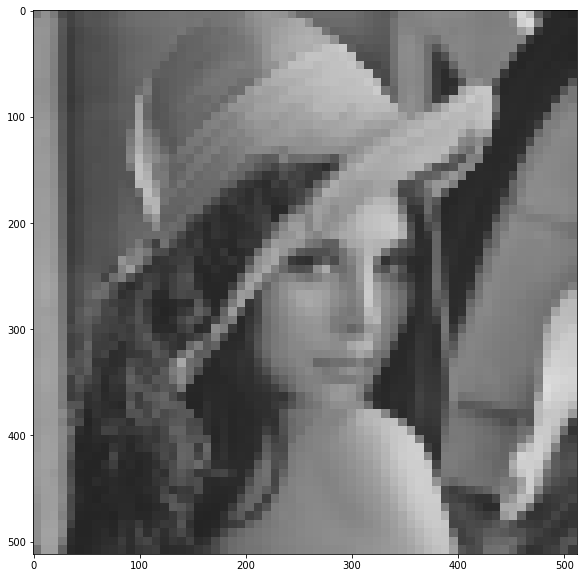

In [7]:
fig = plt.figure(figsize=(10,10))
plt.imshow(obj.out.convert(mode='RGB'))
plt.show()

In [8]:
samples = []
for i, sample in enumerate(os.listdir('../samples/')):
    if path.isdir(sample):
        continue
    else:
        samples.insert(i, Image.open(path.join('../samples/', sample)).convert(mode='HSV').resize(size=(128, 128)))

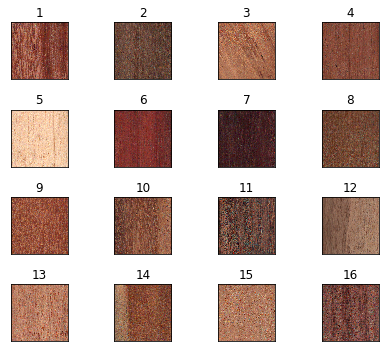

In [9]:
titles = list(range(1, 17))

fig = plt.figure(figsize=(6, 5))

for i, sample in enumerate(samples):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample)

plt.tight_layout()
plt.show()
    

In [10]:
def average_color(sample):
    pix = sample.load()
    totals = [0.0, 0.0, 0.0]
    for y in range(sample.size[1]):
        for x in range(sample.size[0]):
            color = pix[x,y]
            for c in range(3):
                totals[c] += color[c] ** 2.2
    count = sample.size[0] * sample.size[1]
    color = tuple(int(round((totals[c] / count) ** (1/2.2))) for c in range(3))
    return color

In [11]:
ord_samples, ord_titles = zip(*sorted(zip(samples,titles), key=lambda item: average_color(item[0])[2]))

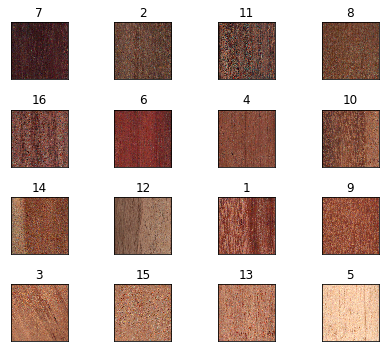

In [12]:
fig = plt.figure(figsize=(6, 5))

for i, sample in enumerate(ord_samples):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(ord_titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample)

plt.tight_layout()
plt.show()

In [13]:
colors = []
for i, sample in enumerate(ord_samples):
    colors.insert(i, average_color(sample.convert(mode='RGB')))

In [14]:
colors

[(67, 36, 36),
 (103, 72, 58),
 (106, 74, 63),
 (114, 73, 54),
 (120, 76, 67),
 (122, 52, 47),
 (131, 75, 59),
 (134, 84, 64),
 (139, 89, 66),
 (143, 107, 88),
 (144, 81, 66),
 (151, 84, 63),
 (170, 111, 82),
 (175, 123, 97),
 (182, 124, 98),
 (241, 199, 165)]

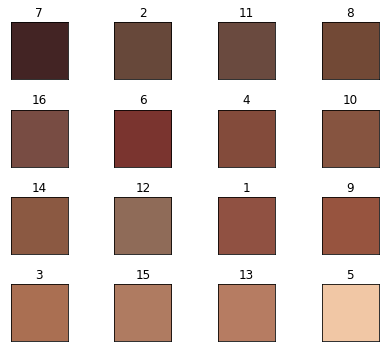

In [15]:
fig = plt.figure(figsize=(6, 5))

for i, color in enumerate(colors):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_title(ord_titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(Image.new(color=color, size=(128,128), mode='RGB'))

plt.tight_layout()
plt.show()

In [16]:
rgb = Image.fromarray(np.array(colors, dtype='uint8').reshape(1, 16, 3), mode='RGB')

hsl = np.array(rgb.convert(mode='HSV'))

In [17]:
rgb_scale = Image.fromarray(np.repeat(hsl, 2, axis=0), mode='HSV').convert(mode='RGB')
i_scale = Image.fromarray(np.repeat(hsl[...,2], 2, axis=0), mode='L').convert(mode='RGB')

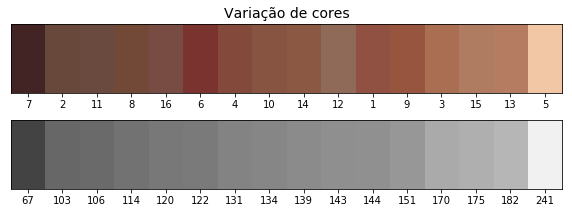

In [18]:
labels = [i for i in hsl[..., 2].flat]
index = np.arange(0, 16)

fig = plt.figure(figsize=(10,3))

ax1 = fig.add_subplot(211)
plt.xticks(index, ord_titles)
plt.yticks([])
ax1.set_title('Variação de cores', fontsize=14)
ax1.imshow(rgb_scale)


ax2 = fig.add_subplot(212)
plt.xticks(index, labels)
plt.yticks([])
ax2.imshow(i_scale)


plt.tight_layout()

plt.show()

In [33]:
from bisect import bisect_right, bisect_left

In [20]:
boundaries = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240]
pallete = [(67, 36, 36),
 (103, 72, 58),
 (106, 74, 63),
 (114, 73, 54),
 (120, 76, 67),
 (122, 52, 47),
 (131, 75, 59),
 (134, 84, 64),
 (139, 89, 66),
 (143, 107, 88),
 (144, 81, 66),
 (151, 84, 63),
 (170, 111, 82),
 (175, 123, 97),
 (182, 124, 98),
 (241, 199, 165)]

In [34]:
def recolor(pixel, boundaries, pallete):
    i = bisect_left(boundaries, pixel)
    return pallete[i]

In [35]:
img = np.array(obj.out)

In [36]:
recolor(img[0,0], boundaries, pallete)

(134, 84, 64)

In [37]:
img_out = np.zeros(shape=(512,512,3), dtype='uint8')


In [38]:
for i in range(img.shape[0]):
    for j in range(img.shape[0]):
        img_out[i, j] = recolor(img[i, j], boundaries, pallete)

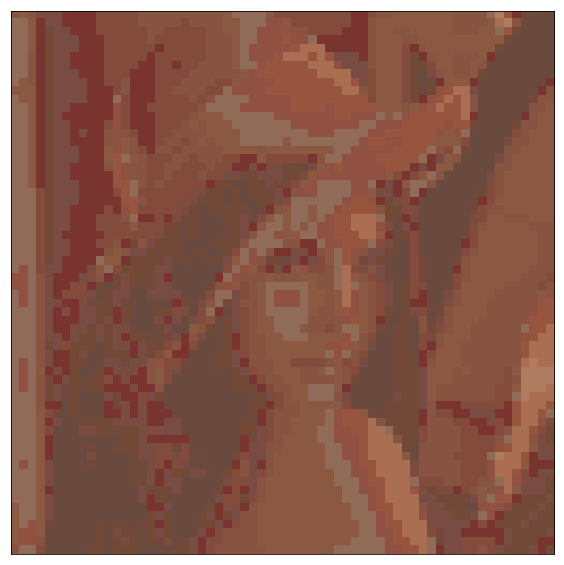

In [39]:
fig = plt.figure(figsize=(10,10))
plt.yticks([])
plt.xticks([])
plt.imshow(img_out)
plt.show()